### NVAR $\mathbf{W}^{out}$ Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings
from IPython.display import clear_output, display
import sympy as sp

from NVAR import *
from utils import RMSE

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
plt.rcParams.update({'font.size': 12})

In [2]:
lorenz = np.loadtxt('./datasets/py-lorenz_RK4_100.csv', delimiter=",", dtype='float64')
lorenz_scaled = np.loadtxt('./datasets/py-lorenz-scaled_RK4_100.csv', delimiter=",", dtype='float64')

# data = lorenz[:,1:]
# target = lorenz[1:,1:]
data = lorenz_scaled[:,1:]
target = lorenz_scaled[1:,1:]

k=4
# k=8
# k=16

train_start=1000
train_end=8000
test_start=train_end
test_end=10000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [3]:
fullmodel = NVARModel(k=4, s=4, reg=1e-6, nonlinearFunc=quadraticCombination)
fullmodel.train(data, target, train_indices)

In [4]:
def get_symbolic_state_labels(k, d, nonlinearFunc=None, extraNonlinearFunc=None):
    bias = np.array([sp.symbols("1")])
    lin_entries = []
    for i in range(k):
        for j in range(d):
            if i == 0:
                lin_entries.append(sp.symbols(f'x(t)_{j+1}'))
            elif i == 1:
                lin_entries.append(sp.symbols(f'x(t-s)_{j+1}'))
            else:
                lin_entries.append(sp.symbols(f'x(t-{i}s)_{j+1}'))
    linarray = np.array(lin_entries)
    lin = np.reshape(linarray, (linarray.shape[0],1))
    zipped = []
    if nonlinearFunc != None and extraNonlinearFunc != None:
        nonlin = nonlinearFunc(lin)
        extranonlin = extraNonlinearFunc(np.vstack([lin, nonlin]))
        arr = np.vstack(
            [
                1,
                lin,
                nonlin,
                extranonlin
            ]
        )
        for i in range(len(arr)):
            if i < 1:
                zipped.append([arr[i,0], 'bias'])
            elif i < 1 + len(lin):
                zipped.append([arr[i,0], 'linear']) 
            elif i < 1 + len(lin) + len(nonlin):
                zipped.append([arr[i,0], 'nonlinear'])
            elif i < 1 + len(lin) + len(nonlin) + len(extranonlin):
                zipped.append([arr[i,0], 'extra-nonlinear'])
        zipped = np.array(zipped)
        return zipped
    elif nonlinearFunc != None:
        nonlin = nonlinearFunc(lin)
        arr = np.vstack(
            [
                1,
                lin,
                nonlin
            ]
        )
        for i in range(len(arr)):
            if i < 1:
                zipped.append([arr[i,0], 'bias'])
            elif i < 1 + len(lin):
                zipped.append([arr[i,0], 'linear']) 
            elif i < 1 + len(lin) + len(nonlin):
                zipped.append([arr[i,0], 'nonlinear'])
        zipped = np.array(zipped)
        return zipped
    else:
        arr = np.vstack(
            [
                1,
                lin
            ]
        )
        for i in range(len(arr)):
            if i < 1:
                zipped.append([arr[i,0], 'bias'])
            elif i < 1 + len(lin):
                zipped.append([arr[i,0], 'linear'])
        zipped = np.array(zipped)
        return zipped

In [5]:
def get_norm_df(symb_state_arr, model):
    dim = model.w.shape[1]
    dict_list = []
    for i in range(dim):
        d = {x : np.linalg.norm(model.w[symb_state_arr[:,1] == x,i])**2 for x in np.unique(symb_state_arr[:,1])}
        d['total'] = np.linalg.norm(model.w[:,i])**2
        dict_list.append(d.copy())
    d = {x : np.linalg.norm(model.w[symb_state_arr[:,1] == x,:])**2 for x in np.unique(symb_state_arr[:,1])}
    d['total'] = np.linalg.norm(model.w)**2
    dict_list.append(d)
    df = pd.DataFrame(
        dict_list,
        index = [f'x_{i+1}' for i in range(dim)] + ['total'],
        # index = ['total', 'x_1', 'x_2', 'x_3'],
        columns=list(np.unique(symb_state_arr[:,1])) + ['total']
        ).transpose()
    return df

In [6]:
symb_state = get_symbolic_state_labels(
    k=4,
    d=3,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = None
)
df = pd.DataFrame(fullmodel.w, columns=['x_1','x_2','x_3'])
df['feature'] = symb_state[:,0]
df['feature_type'] = symb_state[:,1]

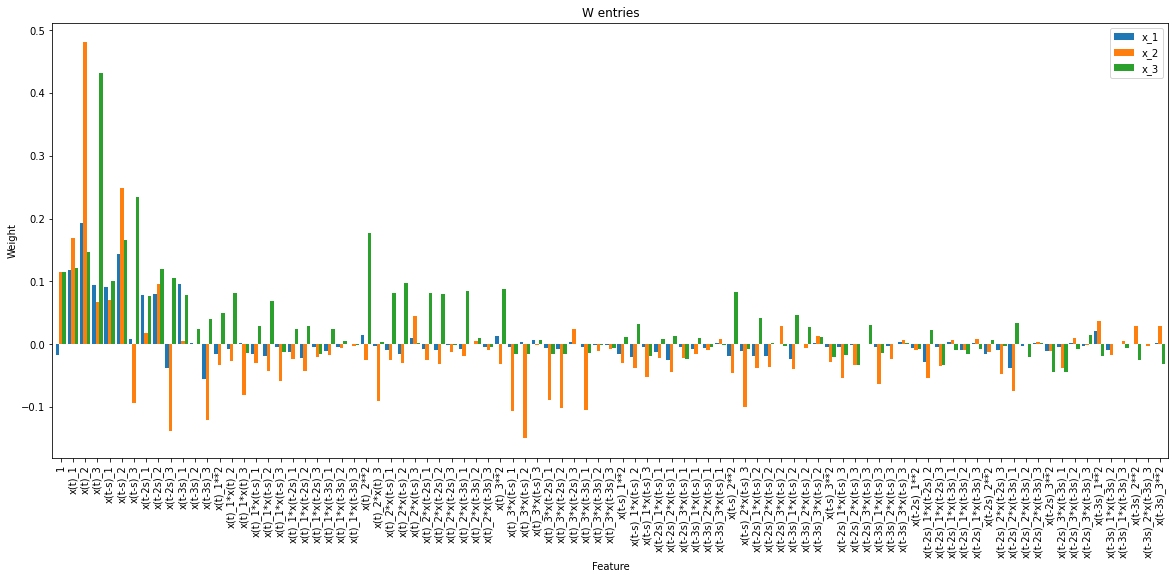

In [7]:
ax = df.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df['feature'])
ax.legend()

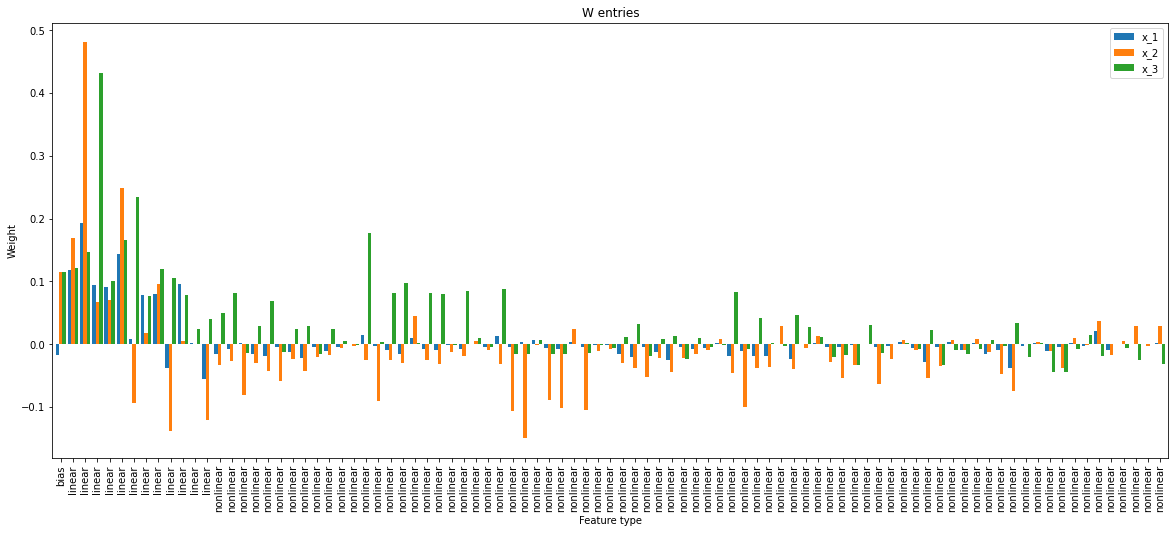

In [8]:
ax = df.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature type',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df['feature_type'])
ax.legend()

In [9]:
feature_norms = np.array([np.linalg.norm(x) for x in fullmodel.w])
df_combined = pd.DataFrame(feature_norms, columns=['feature_norm'])
df_combined['feature'] = symb_state[:,0]
df_combined['feature_type'] = symb_state[:,1]

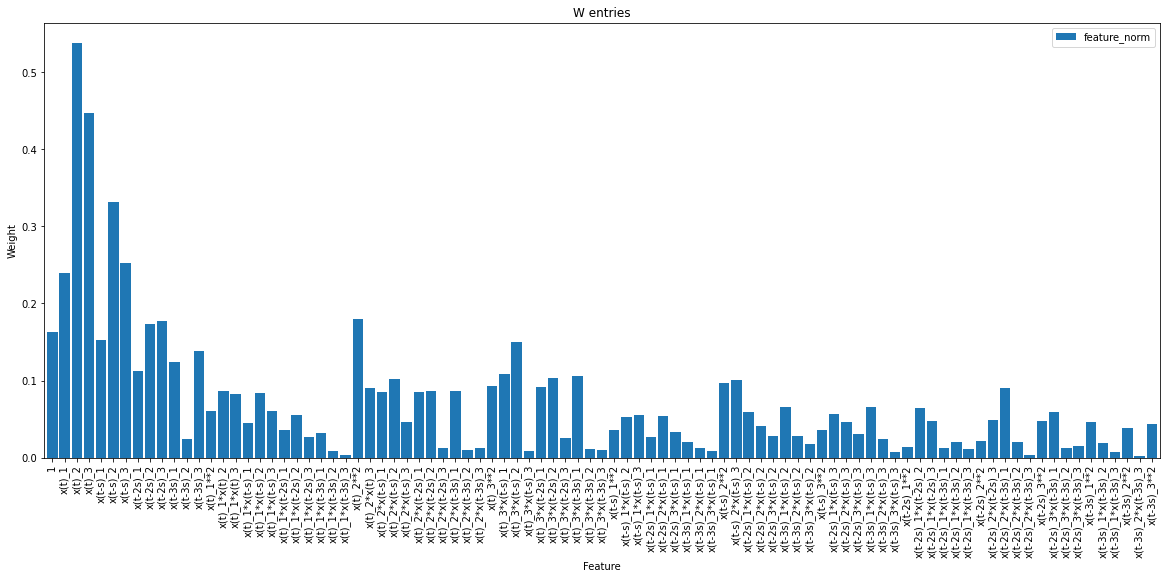

In [10]:
ax = df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df_combined['feature'])
ax.legend()

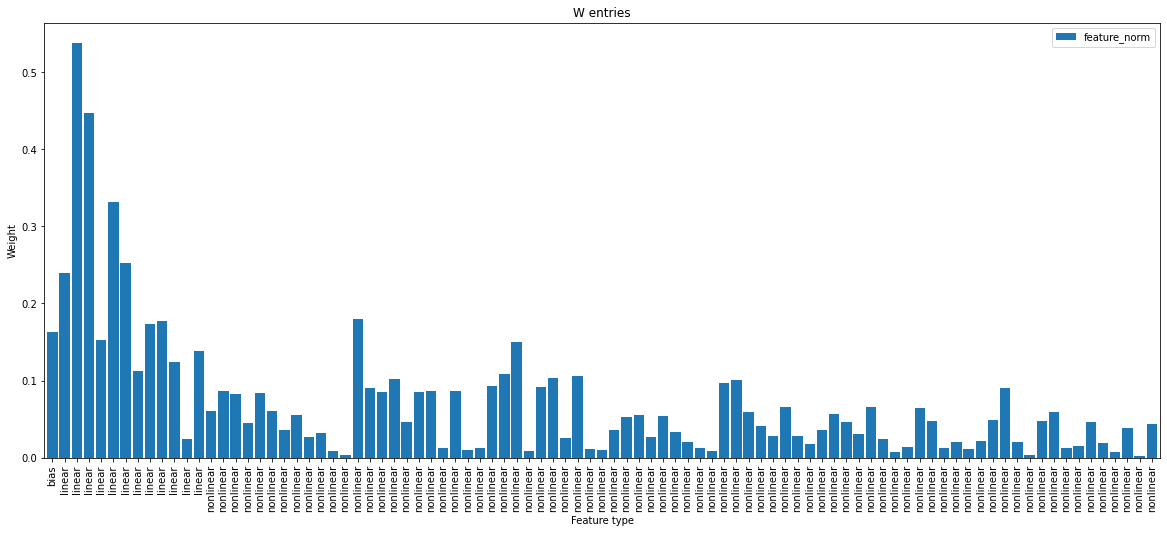

In [11]:
ax = df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature type',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(df_combined['feature_type'])
ax.legend()

In [12]:
get_norm_df(symb_state, fullmodel)

,x_1,x_2,x_3,total
bias,0.000280,0.013293,0.013119,0.026692
linear,0.114769,0.382569,0.353986,0.851324
nonlinear,0.009799,0.149128,0.120500,0.279427
total,0.124848,0.544990,0.487605,1.157443


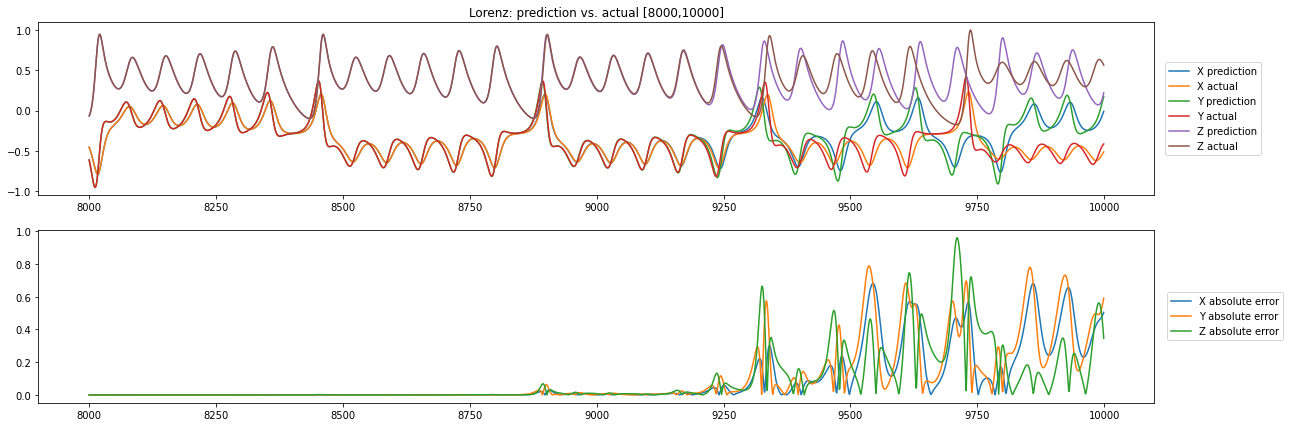

In [13]:
t_forward = test_end-test_start
recursive_out = fullmodel.recursive_predict(data, train_start, train_end, t_forward)
data_end = train_end

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [14]:
RMSE(recursive_out, test_target)

0.3459887161232462

In [15]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
recursive_rmse_arr = []
ctr = 0
total_scens = len(s_grid)*len(reg_grid)
for s in s_grid:
    for r in reg_grid:
        clear_output(wait=True)
        print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  s={s} r={r}')
        model = NVARModel(30, s, r, None)
        model.train(data, target, train_indices)
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
        ctr += 1
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]

print(f'best recursive params (linear model)')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params (linear model)
k  :30
s  :10
reg:0.001


In [16]:
linearmodel = NVARModel(k=30, s=10, reg=0.1, nonlinearFunc=None)
linearmodel.train(data, target, train_indices)

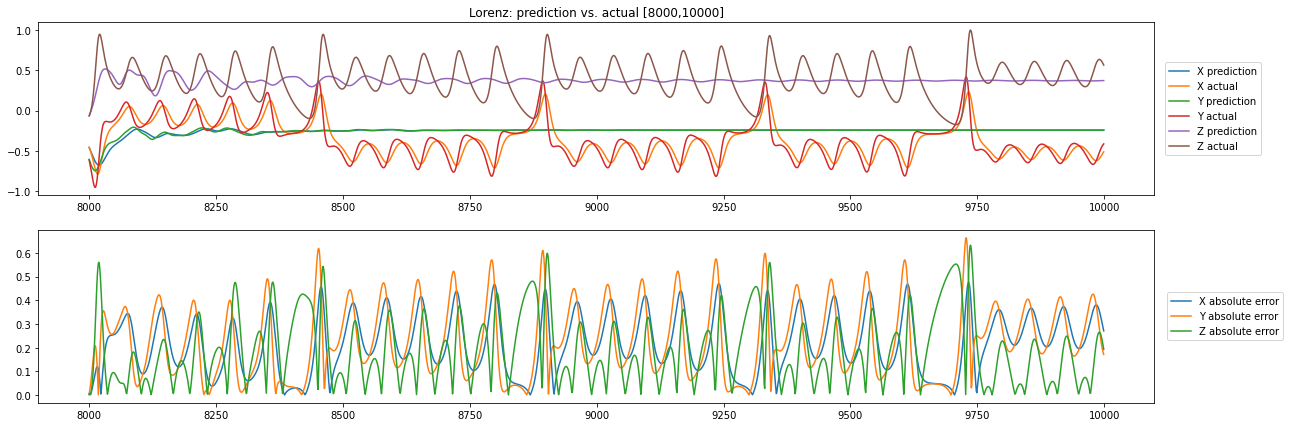

In [17]:
t_forward = test_end-train_end
recursive_out = linearmodel.recursive_predict(data, train_start, train_end, t_forward)
data_end = train_end

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [18]:
RMSE(recursive_out, test_target)

0.4390690488121298

In [19]:
linear_symb_state = get_symbolic_state_labels(
    k=30,
    d=3,
    nonlinearFunc = None,
    extraNonlinearFunc = None
)
linear_df = pd.DataFrame(linearmodel.w, columns=['x_1','x_2','x_3'])
linear_df['feature'] = linear_symb_state[:,0]
linear_df['feature_type'] = linear_symb_state[:,1]

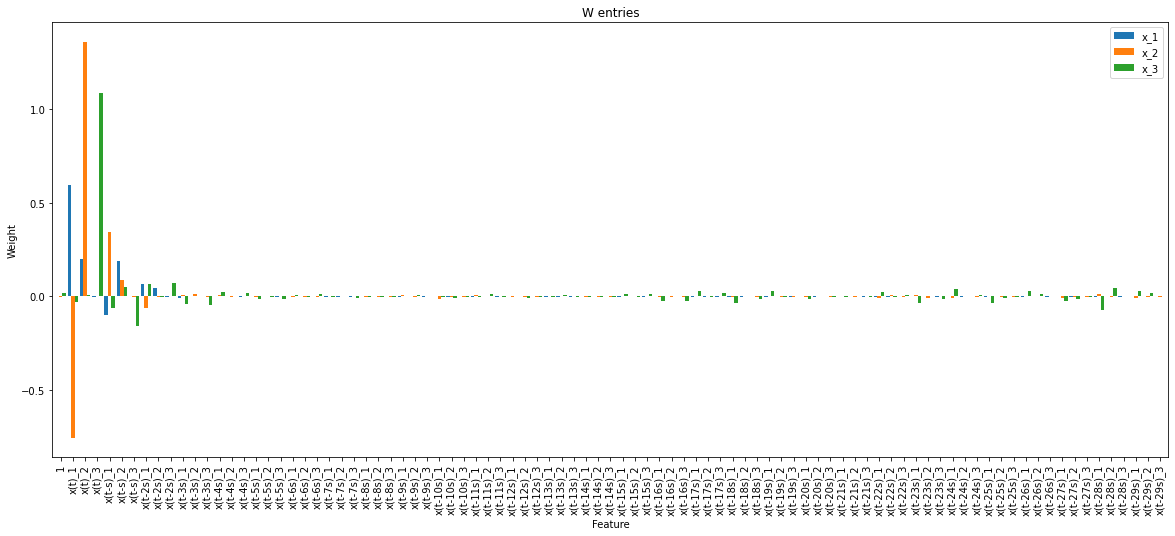

In [20]:
ax = linear_df.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(linear_df['feature'])
ax.legend()

In [21]:
linear_feature_norms = np.array([np.linalg.norm(x) for x in linearmodel.w])
linear_df_combined = pd.DataFrame(linear_feature_norms, columns=['feature_norm'])
linear_df_combined['feature'] = linear_symb_state[:,0]
linear_df_combined['feature_type'] = linear_symb_state[:,1]

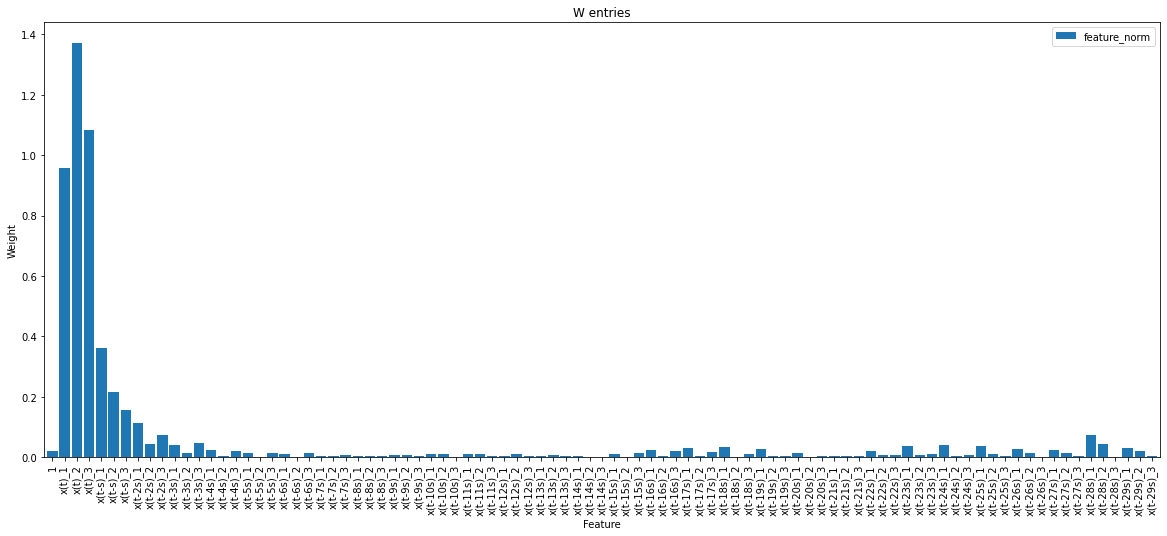

In [22]:
ax = linear_df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(linear_df_combined['feature'])
ax.legend()

In [23]:
get_norm_df(linear_symb_state, linearmodel)

,x_1,x_2,x_3,total
bias,6.364575e-07,0.000016,0.000382,0.000399
linear,4.428723e-01,2.535849,1.243436,4.222158
total,4.428729e-01,2.535865,1.243818,4.222557


In [24]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
recursive_rmse_arr = []
ctr = 0
total_scens = len(s_grid)*len(reg_grid)
for s in s_grid:
    for r in reg_grid:
        clear_output(wait=True)
        print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  s={s} r={r}')
        model = NVARModel(15, s, r, np.tanh, None)
        model.train(data, target, train_indices)
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
        ctr += 1
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]

print(f'best recursive params (tanh model)')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params (tanh model)
k  :15
s  :10
reg:0.1


In [25]:
tanh_model = NVARModel(k=15, s=10, reg=0.1, nonlinearFunc=np.tanh)
tanh_model.train(data, target, train_indices)

In [26]:
t_forward = test_end-train_end
# t_forward = 100
recursive_out = tanh_model.recursive_predict(data, train_start, train_end, t_forward)
data_end = train_end

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
RMSE(recursive_out, test_target)

0.49997883876550153

In [ ]:
tanh_symb_state = get_symbolic_state_labels(
    k=15,
    d=3,
    nonlinearFunc = lambda x: np.array([[sp.tanh(y[0])] for y in x]),
    extraNonlinearFunc = None
)
tanh_df = pd.DataFrame(tanh_model.w, columns=['x_1','x_2','x_3'])
tanh_df['feature'] = tanh_symb_state[:,0]
tanh_df['feature_type'] = tanh_symb_state[:,1]

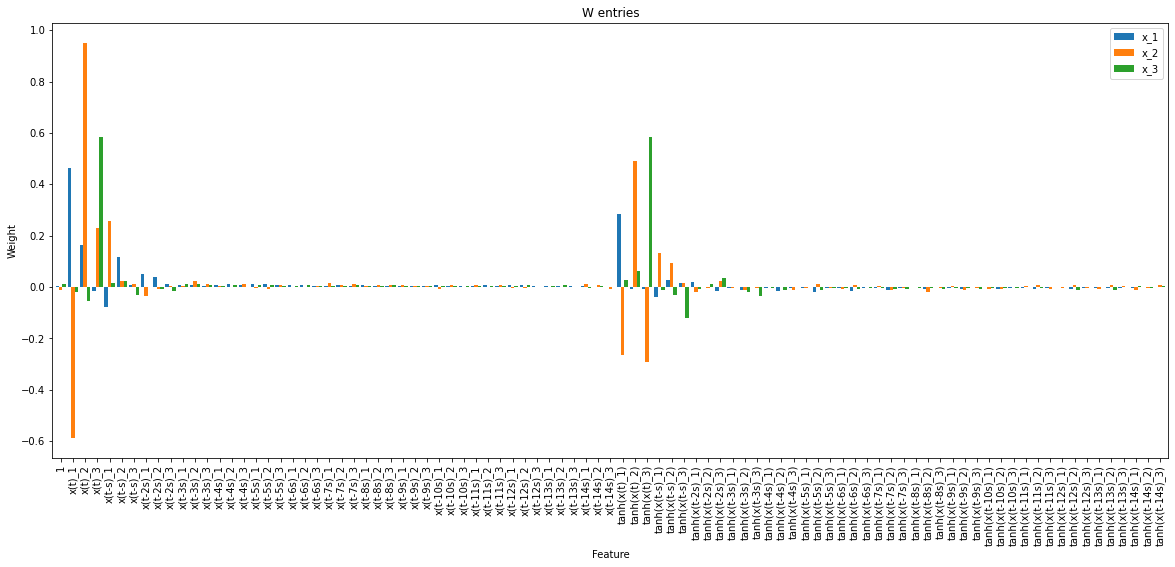

In [ ]:
ax = tanh_df.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(tanh_df['feature'])
ax.legend()

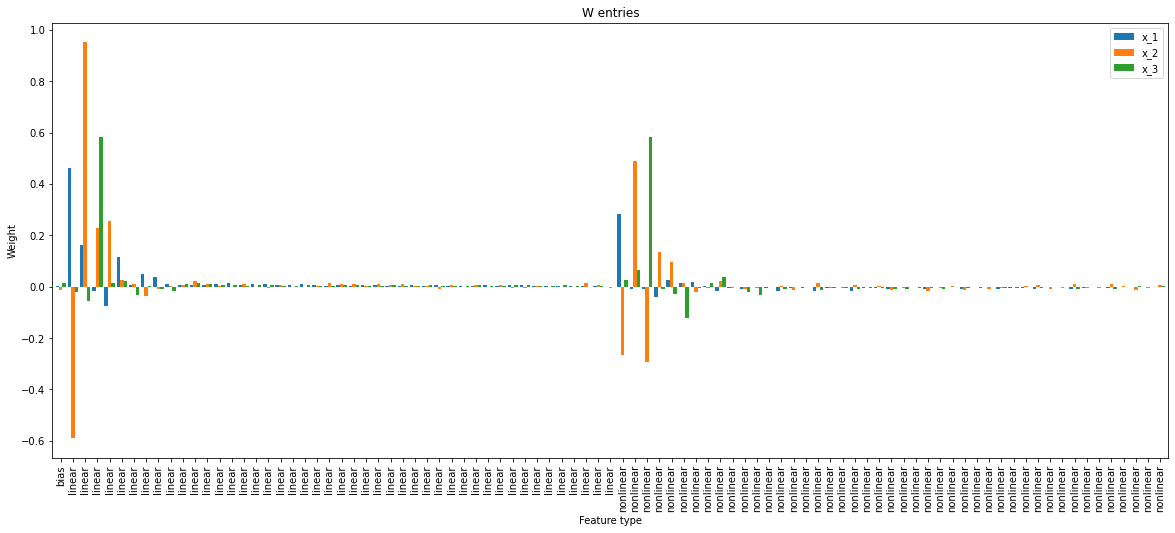

In [ ]:
ax = tanh_df.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature type',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(tanh_df['feature_type'])
ax.legend()

In [ ]:
tanh_feature_norms = np.array([np.linalg.norm(x) for x in tanh_model.w])
tanh_df_combined = pd.DataFrame(tanh_feature_norms, columns=['feature_norm'])
tanh_df_combined['feature'] = tanh_symb_state[:,0]
tanh_df_combined['feature_type'] = tanh_symb_state[:,1]

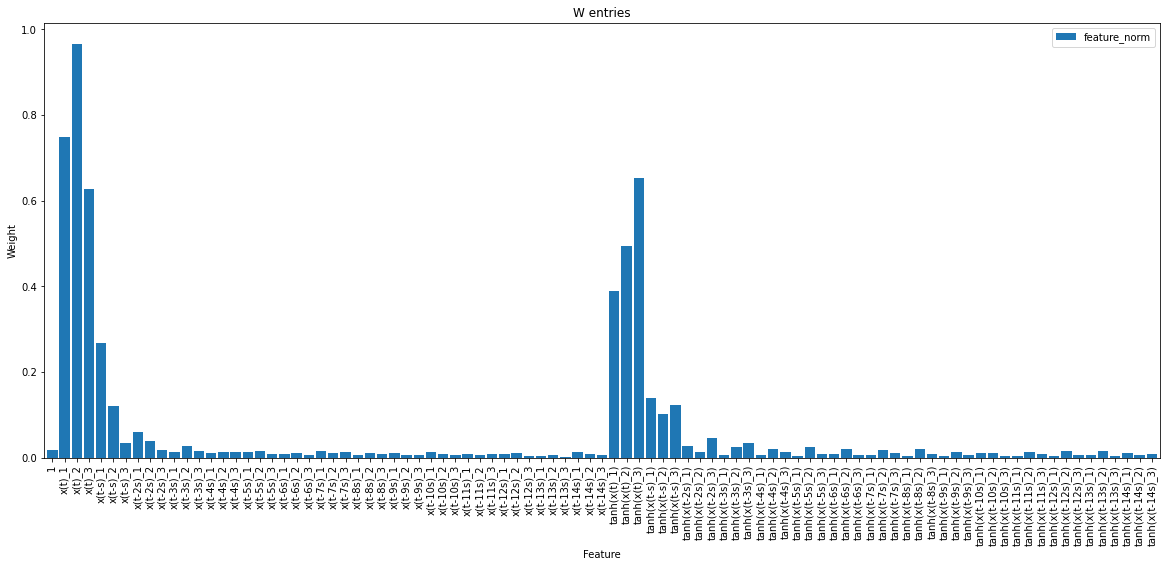

In [ ]:
ax = tanh_df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(tanh_df_combined['feature'])
ax.legend()

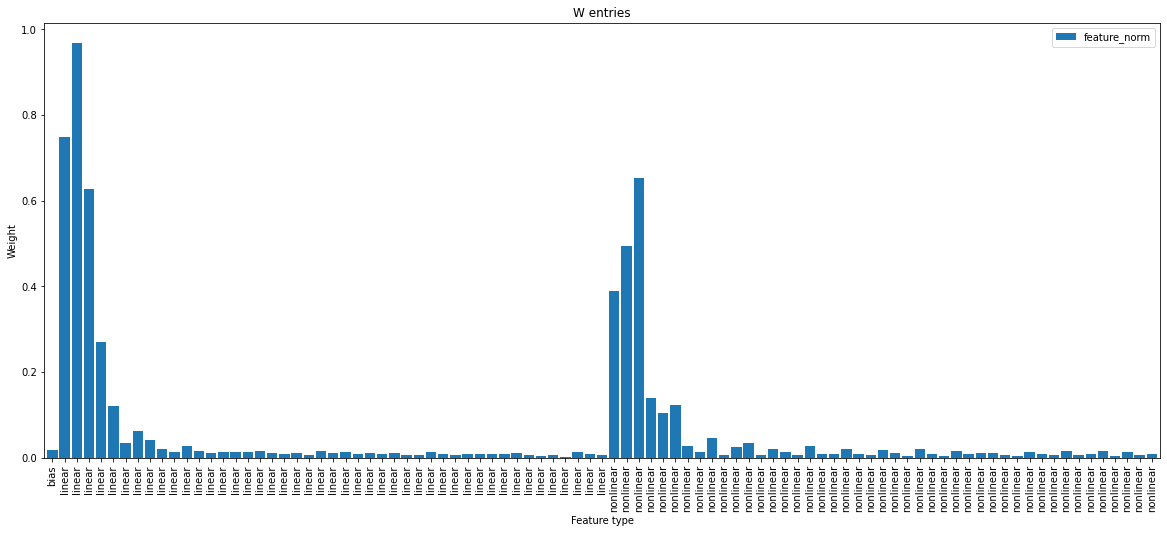

In [ ]:
ax = tanh_df_combined.plot(
    kind='bar',
    figsize=(20,8),
    xlabel='Feature type',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(tanh_df_combined['feature_type'])
ax.legend()

In [ ]:
get_norm_df(tanh_symb_state, tanh_model)

,x_1,x_2,x_3,total
bias,0.000003,0.000127,0.000163,0.000293
linear,0.265628,1.374345,0.347121,1.987094
nonlinear,0.085257,0.427240,0.363634,0.876130
total,0.350888,1.801711,0.710918,2.863517


In [ ]:
model_arr = []
s_grid = [2,3,4,5,6,7,8,10]
reg_grid = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
recursive_rmse_arr = []
ctr = 0
total_scens = len(s_grid)*len(reg_grid)
for s in s_grid:
    for r in reg_grid:
        clear_output(wait=True)
        print(f'done: scen {ctr}/{total_scens-1} ({100*ctr/(total_scens-1):.02f}%) |  s={s} r={r}')
        model = NVARModel(4, s, r, quadraticCombination, np.tanh)
        model.train(data, target, train_indices)
        recursive_rmse_arr.append(RMSE(test_target,model.recursive_predict(data, train_start, train_end, test_end-test_start)))
        model_arr.append(model)
        ctr += 1
recursive_rmse_arr = np.array(recursive_rmse_arr)
best_recursive_idx = np.argmin(recursive_rmse_arr[~np.isnan(recursive_rmse_arr)])
best_recursive_model = [model_arr[i] for i in range(len(model_arr)) if ~np.isnan(recursive_rmse_arr)[i]][best_recursive_idx]

print(f'best recursive params (tanh extra nonlinearity')
print(f'k  :{best_recursive_model.k}')
print(f's  :{best_recursive_model.s}')
print(f'reg:{best_recursive_model.reg}')

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params (tanh extra nonlinearity
k  :4
s  :3
reg:0.01


In [ ]:
extra_nl_model = NVARModel(k=4, s=3, reg=0.01, nonlinearFunc=quadraticCombination, extraNonlinearFunc=np.tanh)
extra_nl_model.train(data, target, train_indices)

In [ ]:
extra_nl_symb_state = get_symbolic_state_labels(
    k=4,
    d=3,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = lambda x: np.array([[sp.tanh(y[0])] for y in x])
)
extra_nl_df = pd.DataFrame(extra_nl_model.w, columns=['x_1','x_2','x_3'])
extra_nl_df['feature'] = extra_nl_symb_state[:,0]
extra_nl_df['feature_type'] = extra_nl_symb_state[:,1]

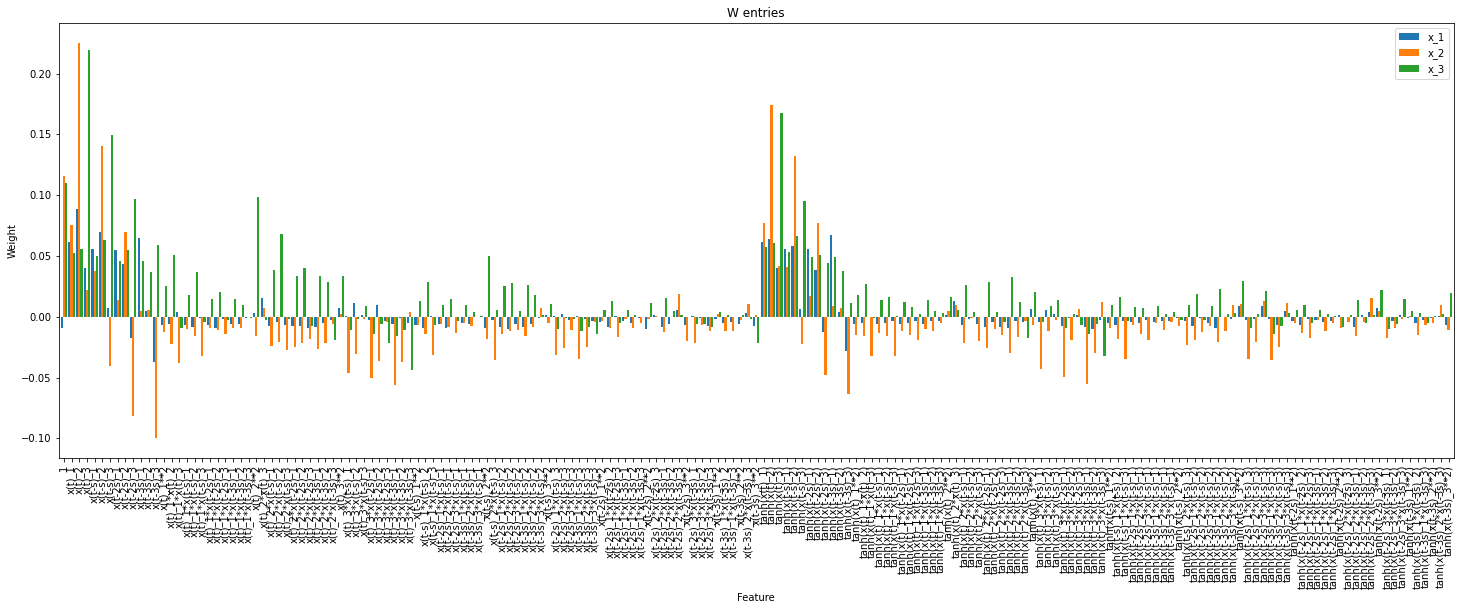

In [ ]:
ax = extra_nl_df.plot(
    kind='bar',
    figsize=(25,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(extra_nl_df['feature'])
ax.legend()

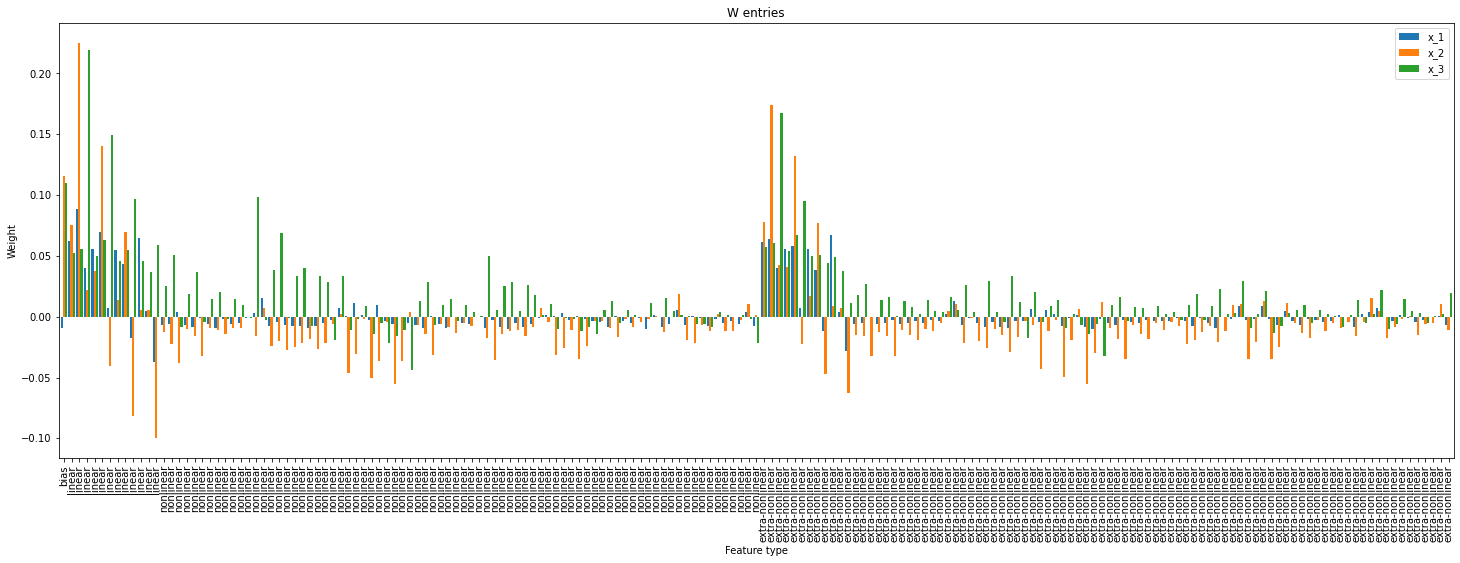

In [ ]:
ax = extra_nl_df.plot(
    kind='bar',
    figsize=(25,8),
    xlabel='Feature type',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(extra_nl_df['feature_type'])
ax.legend()

In [ ]:
extra_nl_feature_norms = np.array([np.linalg.norm(x) for x in extra_nl_model.w])
extra_nl_df_combined = pd.DataFrame(extra_nl_feature_norms, columns=['feature_norm'])
extra_nl_df_combined['feature'] = extra_nl_symb_state[:,0]
extra_nl_df_combined['feature_type'] = extra_nl_symb_state[:,1]

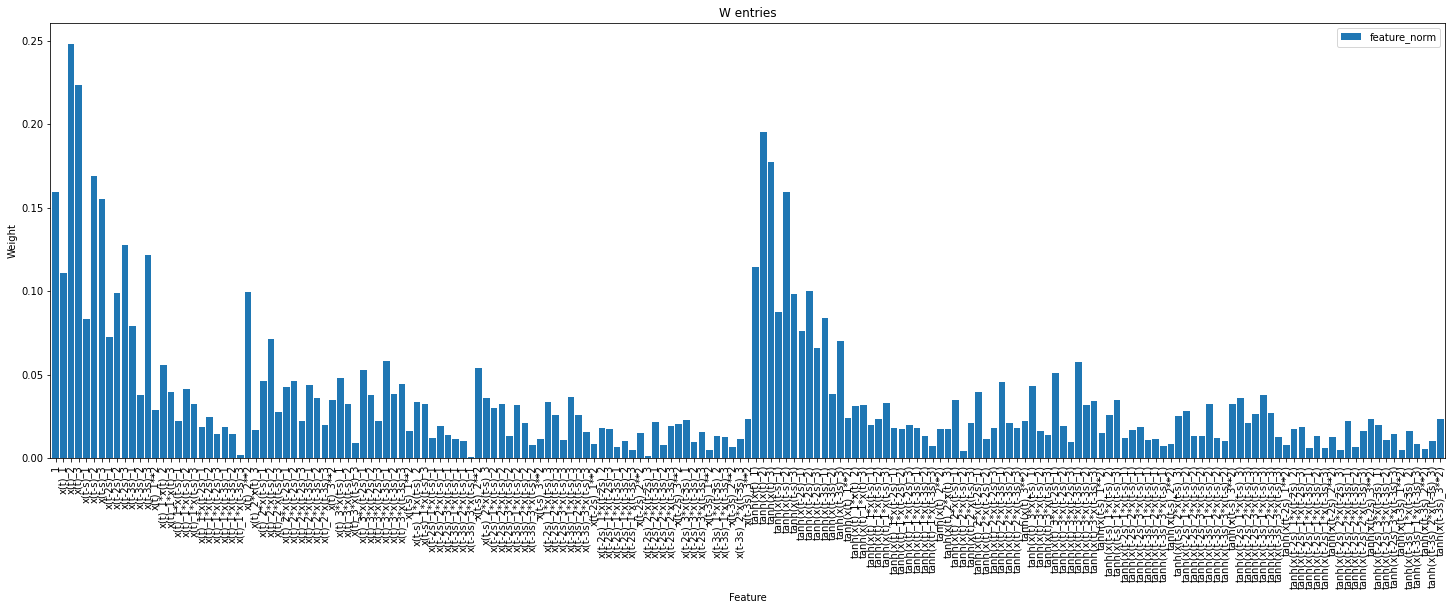

In [ ]:
ax = extra_nl_df_combined.plot(
    kind='bar',
    figsize=(25,8),
    xlabel='Feature',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(extra_nl_df_combined['feature'])
ax.legend()

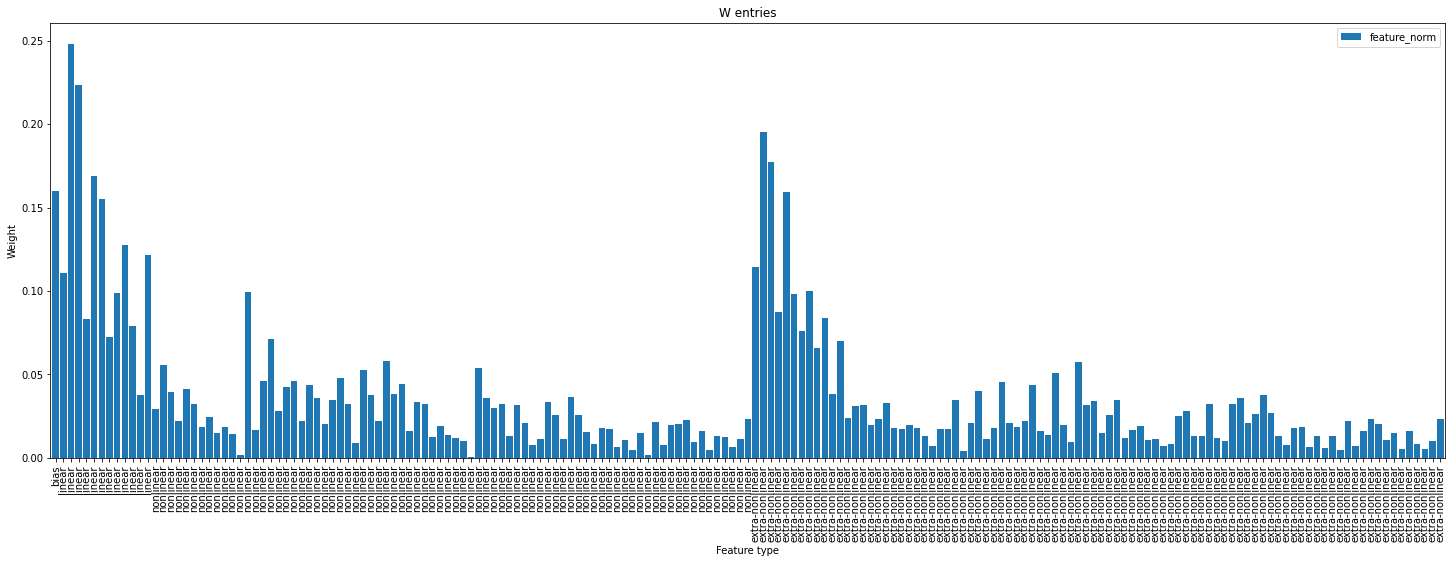

In [ ]:
ax = extra_nl_df_combined.plot(
    kind='bar',
    figsize=(25,8),
    xlabel='Feature type',
    ylabel='Weight',
    title='W entries',
    width=0.85
    )
ax.set_xticklabels(extra_nl_df_combined['feature_type'])
ax.legend()

In [ ]:
get_norm_df(extra_nl_symb_state, extra_nl_model)

,x_1,x_2,x_3,total
bias,0.000087,0.013328,0.012084,0.025500
extra-nonlinear,0.028222,0.096833,0.075075,0.200130
linear,0.031953,0.101386,0.104045,0.237384
nonlinear,0.002810,0.030306,0.039585,0.072701
total,0.063071,0.241854,0.230789,0.535714


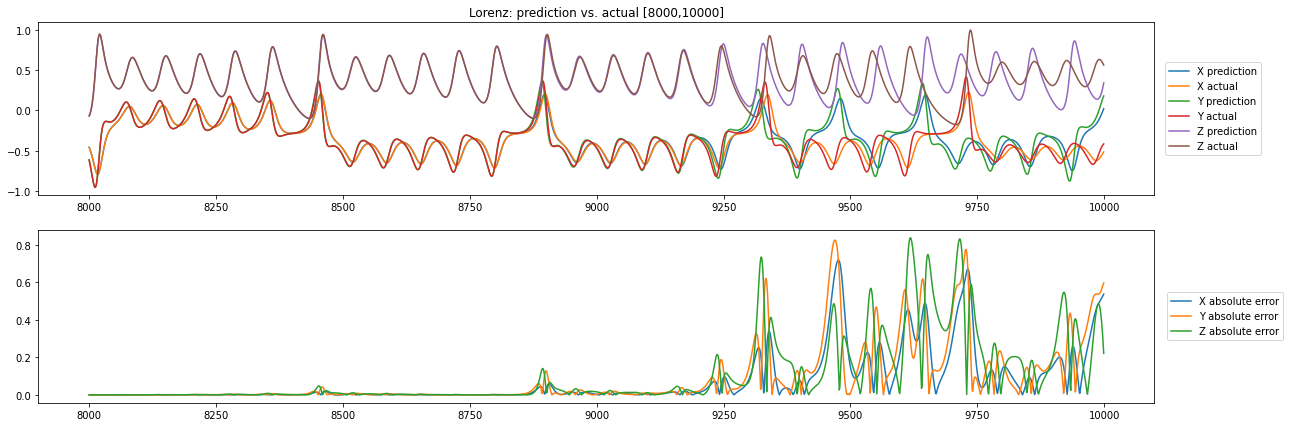

In [ ]:
t_forward = test_end-train_end
# t_forward = 100
recursive_out = extra_nl_model.recursive_predict(data, train_start, train_end, t_forward)
data_end = train_end

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Z prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Z actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Z absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()

In [ ]:
RMSE(test_target, extra_nl_model.recursive_predict(data, train_start, train_end, t_forward))

0.31944458057199426

In [ ]:
RMSE(test_target, fullmodel.recursive_predict(data, train_start, train_end, t_forward))

0.3459887161232462

In [ ]:
np.linalg.svd(extra_nl_model.w.T @ extra_nl_model.w)[0]

array([[ 0.35912674, -0.09101232,  0.92884054],
       [ 0.72698151, -0.59682257, -0.33955958],
       [ 0.5852571 ,  0.79719482, -0.14817067]])

In [ ]:
np.linalg.svd(extra_nl_model.w)

(array([[ 2.53252523e-01, -4.54138579e-02, -4.28862853e-01, -6.22465244e-03,  2.16891531e-01,  1.05088016e-01, -2.17765920e-02,  2.58130379e-01,  8.20089314e-02, -4.82198602e-02,  3.33028307e-01, -1.54867098e-02, -9.83354591e-02, -4.27440582e-02, -4.04392739e-02,  9.96734830e-02, -4.04557287e-02, -5.67370336e-02,  5.59049273e-02, -3.46367268e-02, -5.34936591e-02,  1.54107799e-02, -3.18984640e-02, -2.48769775e-02, -4.64625699e-03, -4.63571048e-02,  7.96886185e-02, -3.71982077e-02, -5.28938546e-02,  1.11400572e-02, -3.22875119e-02, -4.57919337e-02, -1.33974438e-02, -3.17322135e-02, -1.65310351e-02,  1.46221397e-02,  9.84065959e-03,  9.82506868e-02,  1.26011167e-01,  4.39566804e-03,  8.67000775e-02,  1.27298936e-01,  6.15945973e-03,  7.98627136e-02,  7.27074601e-02,  2.55517881e-03, -3.82433124e-02, -5.46887025e-02,  6.67696622e-02, -3.22671174e-02, -5.21577223e-02,  2.77016616e-02, -2.90278648e-02, -2.40246314e-02, -3.10519872e-03, -7.12236273e-02,  4.20015511e-02, -4.87388268e-02, -6.73

In [ ]:
np.linalg.svd(extra_nl_model.w @ extra_nl_model.w.T)[0]

array([[-2.53252523e-01,  4.54138579e-02, -4.28862853e-01, -5.94350269e-01,  3.96691401e-01, -1.80400190e-02, -3.23640397e-01, -1.37860066e-02, -1.08655795e-03,  6.72699052e-02,  2.41136882e-02,  5.53233217e-03, -8.05645538e-02, -2.11678171e-04,  9.63731925e-02,  4.41959801e-02,  4.80412830e-03,  3.90991249e-02,  1.82429663e-02, -1.30903684e-01,  1.09191531e-01,  6.00246396e-03,  1.45167154e-01, -1.21333745e-04, -2.07064471e-02,  2.37579034e-02,  5.12674802e-03,  1.41966400e-03, -5.06281280e-02,  1.19390253e-02,  2.50245580e-02, -5.58810526e-02, -3.57394633e-02,  1.95007441e-02,  3.81691525e-03,  2.75692804e-02, -4.77351782e-02,  7.47346682e-03,  3.54455864e-02,  2.46112569e-02,  7.85606177e-03,  4.66242167e-02, -3.44481086e-03, -3.81743062e-02, -7.99942164e-03,  8.45766004e-03, -1.41849784e-02, -1.39488883e-02,  2.75684273e-03, -3.12342959e-02,  2.65092650e-03,  1.07724347e-02,  5.15467192e-02,  2.05176819e-02, -7.23001602e-03,  3.08273503e-02,  1.51116061e-02,  1.52833265e-02,  2.563